# DGE analyses for **anther** in **wheat** using `r-sleuth` 
In this notebook, DGE-analyses for **anther vs all-other-tissues** are prepared:
 * 1. anther/stamen wt vs all-flower: subsampling only flower samples
         - `null = dataset`
         - `full = dataset+is_anther[yes-no]`
 * 2. anther wt vs anther mutants: subsampling only anther/stamen samples
     - `null = dataset`
     - `full = dataset+is_mutant[yes-no]`

## Import and prepare data

In [1]:
library(sleuth, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(vsn)
library(pheatmap)
library(shiny)
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLappl

In [2]:
set.seed(42) # For reproducibility of results

In [3]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
# stringsAsfactors has to be truse for deseq2 design
wheat_metadata <- read.table("wheat_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
wheat_meta <- select(wheat_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(wheat_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# exclude outliers detected during exploratory analyses: ERR781040, ERR1457187
wheat_meta <- filter(wheat_meta, ID != "ERR781040")
wheat_meta <- filter(wheat_meta, ID != "ERR1457187")
# exclude outliers detected during first sleuth runs: ERR1457171, ERR1457170, they are from developmental dataset, rachis/grain samples
wheat_meta <- filter(wheat_meta, ID != "ERR1457171")
wheat_meta <- filter(wheat_meta, ID != "ERR1457170")
# add rownames for deseq2 to identify rows with count-columns
rownames(wheat_meta) <- wheat_meta$ID
glimpse(wheat_meta)

Rows: 215
Columns: 22
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6…
$ cultivar            <chr> "303-B", "303-B", "303-B", "C303A", "C303A", "C30…
$ gm                  <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt"…
$ zadoc_scale         <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
$ intermediate_age    <chr> "Heading", "Heading", "Heading", "Heading", "Head…
$ high_level_age      <chr> "Reproductive", "Reproductive", "Reproductive", "…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ high_level_tissue   <chr> "inflorescence", "inflorescence", "inflorescence"…
$ treatment           <chr> "control", "control", "control", "mutant", "mutan…
$ rna_extraction      <chr> "trizol", "trizol", "trizol", "trizol", "trizol",…
$ rna_enrichment      <chr> "o

# 1. Anther contrast: **anther/stamen wt vs all-flower**
## 1.1 Create contrast variables
 * **is_anther:** yes = only anther wt tissues, no = flower tissues
 * first subsampling only flower samples!
 * modells:
         - `null = dataset`
         - `full = dataset+is_anther[yes-no]`

In [4]:
# here filter to flower tissues only
is_flower <- wheat_meta %>% filter(high_level_tissue == "inflorescence") %>% select(ID, dataset, intermediate_tissue, gm) 
# here we select samples that are anther/stamen tissue
is_anther <- is_flower %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen") %>% 
                                              add_column(is_anther = "yes") %>% 
                                              select(ID, dataset, is_anther, gm)
# here we filter for wt-anther samples only
is_anther_yes <- is_anther %>% filter(gm == "wt") %>% select(ID, dataset, is_anther)
# here we select samples that are not anther/stamen, but are flower
is_anther_no <- is_flower %>% filter(intermediate_tissue != "anther" & intermediate_tissue != "stamen") %>% 
                                              add_column(is_anther = "no") %>% 
                                              select(ID, dataset, is_anther)
# here we join tables of anther or not into one table
wheat_anther1 <- bind_rows(is_anther_yes, is_anther_no)
wheat_anther1$ID <- as.factor(wheat_anther1$ID)
wheat_anther1$dataset <- as.factor(wheat_anther1$dataset)
wheat_anther1$is_anther <- as.factor(wheat_anther1$is_anther)
glimpse(is_flower)
glimpse(is_anther)
glimpse(is_anther_yes)
glimpse(is_anther_no)
glimpse(wheat_anther1)
tail(wheat_anther1, 3)

Rows: 151
Columns: 4
$ ID                  <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR…
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ intermediate_tissue <chr> "anther", "anther", "anther", "anther", "anther",…
$ gm                  <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt"…
Rows: 52
Columns: 4
$ ID        <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR10737430",…
$ dataset   <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility",…
$ is_anther <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "ye…
$ gm        <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt", "wt", "m…
Rows: 23
Columns: 3
$ ID        <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR088963", "…
$ dataset   <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility",…
$ is_anther <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "ye…
Rows: 99
Columns: 3
$ ID        <chr> "SRR7106399", "SRR7106400", "SRR

,ID,dataset,is_anther
,<fct>,<fct>,<fct>
120,SRR6802613,spike_dev,no
121,SRR6802614,spike_dev,no
122,SRR6802615,spike_dev,no


In [5]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
m <- read.delim("wheat_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m, 3)
dim(m)

,target_id,gene
,<chr>,<chr>
1,TraesCHI1A01G000600.1,TraesCHI1A01G000600
2,TraesCHI1A01G000800.1,TraesCHI1A01G000800
3,TraesCHI1A01G001100.1,TraesCHI1A01G001100


[1] 123075      2

In [6]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", wheat_anther1$ID, "abundance.h5")
names(files) <- paste0(wheat_anther1$ID)
head(files)
all(file.exists(files))

SRR10737427 
"../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5" 
                                                 SRR10737428 
"../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5" 
                                                 SRR10737429 
"../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5" 
                                                   CRR088963 
  "../04_Kallisto_allreads_symlinked/CRR088963/abundance.h5" 
                                                   CRR088962 
  "../04_Kallisto_allreads_symlinked/CRR088962/abundance.h5" 
                                                   CRR088961 
  "../04_Kallisto_allreads_symlinked/CRR088961/abundance.h5"

[1] TRUE

In [7]:
s2c_anther1 <- mutate(wheat_anther1, path = files, sample = ID)
head(s2c_anther1, 3)

,ID,dataset,is_anther,path,sample
,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737427,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737427/abundance.h5,SRR10737427
2,SRR10737428,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737428/abundance.h5,SRR10737428
3,SRR10737429,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737429/abundance.h5,SRR10737429


In [8]:
# construct the sleuth-object
so_anther1 <- sleuth_prep(sample_to_covariates = s2c_anther1, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
..........................................................................................................................
normalizing est_counts
59122 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
59122 genes passed the filter
summarizing bootstraps
.................................................
..................................................
.......................


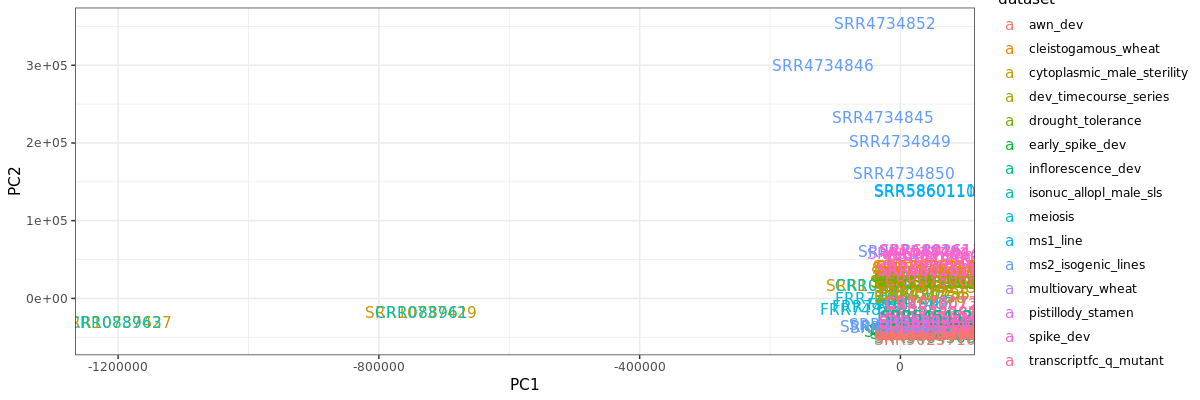

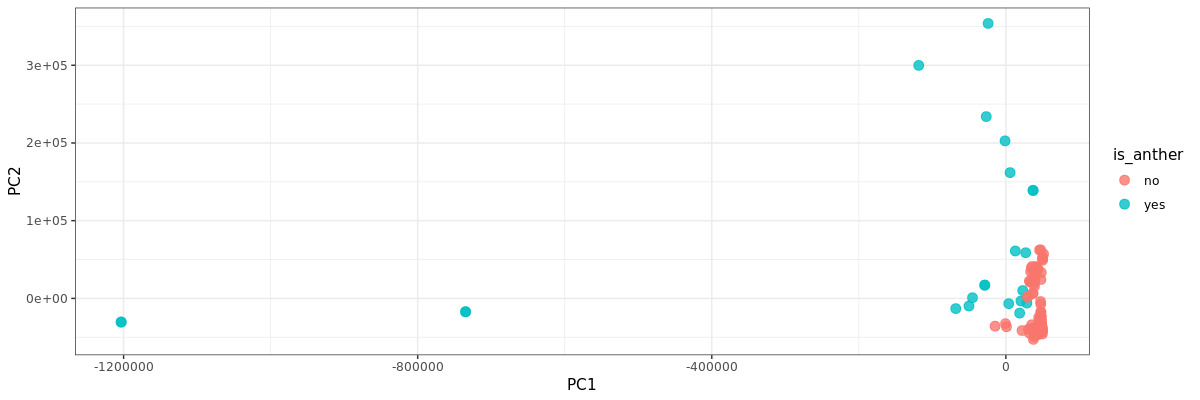

In [9]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_anther1, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_anther1, color_by = 'is_anther',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [11]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
#plot_bootstrap(so_anther1, 'Horvu_MOREX_7H01G200700', color_by = 'is_anther',units='scaled_reads_per_base')

In [12]:
# create models
so_anther1 <- sleuth_fit(so_anther1, ~dataset + is_anther, 'full')
so_anther1 <- sleuth_fit(so_anther1, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1B01G141800
computing variance of betas
fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI1B01G141800
computing variance of betas


In [13]:
# perform DGE test
so_anther1 <- sleuth_lrt(so_anther1, 'reduced', 'full')

In [14]:
models(so_anther1)

[  full  ]
formula:  ~dataset + is_anther 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettranscriptfc_q_mutant
 	is_antheryes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetcleistogamous_wheat
 	datasetcytoplasmic_male_sterility
 	datasetdev_timecourse_series
 	datasetdrought_tolerance
 	datasetearly_spike_dev
 	datasetinflorescence_dev
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetmultiovary_wheat
 	datasetpistillody_stamen
 	datasetspike_dev
 	datasettranscriptfc_q_mutant


In [15]:
table_anther1 <- sleuth_results(so_anther1, 'reduced:full', 'lrt', show_all = FALSE)
sig_anther1_1 <- filter(table_anther1, qval <= 0.1)
glimpse(sig_anther1_1)
sig_anther1_05 <- filter(table_anther1, qval <= 0.05)
glimpse(sig_anther1_05)
sig_anther1_01 <- filter(table_anther1, qval <= 0.01)
glimpse(sig_anther1_01)
# look at table and few of 0.05
head(sig_anther1_05, 5)

Rows: 42,484
Columns: 12
$ target_id       <chr> "TraesCHI1D01G245800", "TraesCHI4D01G264100", "TraesC…
$ pval            <dbl> 1.047492e-32, 3.907654e-32, 1.430970e-31, 2.287470e-3…
$ qval            <dbl> 6.192985e-28, 1.155141e-27, 2.820060e-27, 3.380995e-2…
$ test_stat       <dbl> 141.85242, 139.23769, 136.66011, 135.72867, 126.64447…
$ rss             <dbl> 34.56871, 125.83443, 74.53967, 68.77792, 49.22387, 12…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 5.350127, 5.173196, 4.322440, 3.306386, 5.712252, 6.1…
$ var_obs         <dbl> 1.1901719, 1.6960608, 4.8624576, 3.3748546, 1.0980182…
$ tech_var        <dbl> 0.010365665, 0.022305717, 0.015066559, 0.029288515, 0…
$ sigma_sq        <dbl> 0.3127064, 1.1537170, 0.6815658, 0.6134957, 0.4522890…
$ smooth_sigma_sq <dbl> 0.06673695, 0.07089982, 0.10792601, 0.21446303, 0.060…
$ final_sigma_sq  <dbl> 0.3127064, 1.1537170, 0.6815658, 0.6134957, 0.4522890…
Rows: 36,228
Columns: 12
$ 

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1D01G245800,1.047492e-32,6.192985e-28,141.8524,34.56871,1,5.350127,1.190172,0.010365665,0.3127064,0.06673695,0.3127064
2,TraesCHI4D01G264100,3.907654e-32,1.155141e-27,139.2377,125.83443,1,5.173196,1.696061,0.022305717,1.1537170,0.07089982,1.1537170
3,TraesCHI7A01G579200,1.430970e-31,2.820060e-27,136.6601,74.53967,1,4.322440,4.862458,0.015066559,0.6815658,0.10792601,0.6815658
4,TraesCHI7A01G579100,2.287470e-31,3.380995e-27,135.7287,68.77792,1,3.306386,3.374855,0.029288515,0.6134957,0.21446303,0.6134957
5,TraesCHI3B01G482900,2.222218e-29,2.627639e-25,126.6445,49.22387,1,5.712252,1.098018,0.007747178,0.4522890,0.06094405,0.4522890


In [16]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_anther1_1, file = "deg_wheat_anther1_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_anther1_05, file = "deg_wheat_anther1_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_anther1_01, file = "deg_wheat_anther1_signif0_01.csv", sep = ",", col.names = TRUE)

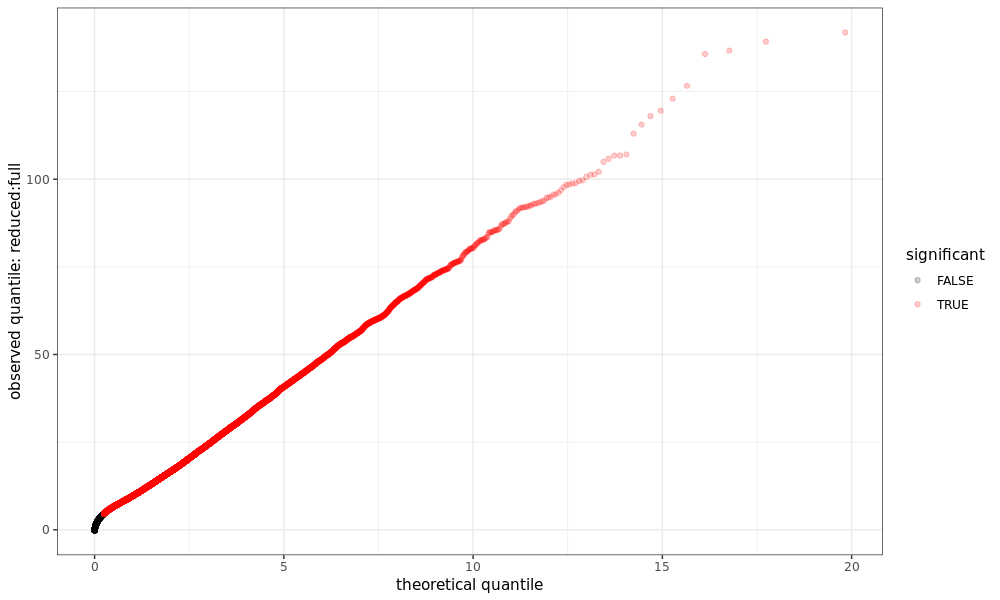

In [17]:
plot_qq(so_anther1, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

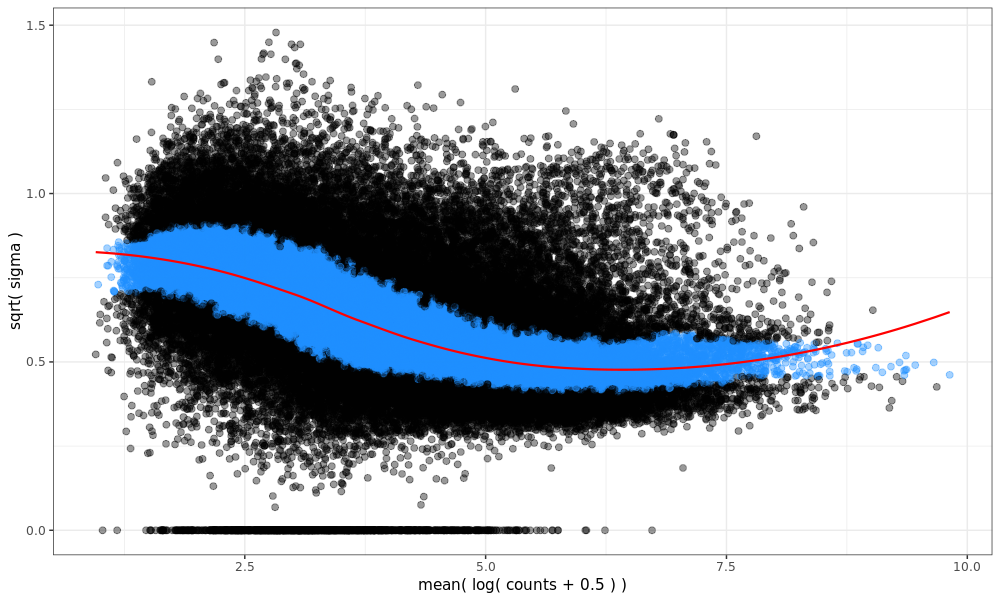

In [18]:
plot_mean_var(so_anther1,which_model="full")

# 2. Anther contrast: **anther wt vs anther mutants**
## 2.1 Create contrast variables
 * **is_mutant:** yes = only anther/stamen wt tissues, no = only anther/stamen mutant tissues
 * first subsampling only anther/stamen samples!
 * modells:
     - `null = dataset`
     - `full = dataset+is_mutant[yes-no]`

In [19]:
# here filter for anther tissues only
is_anther <- wheat_meta %>% filter(intermediate_tissue == "anther" | intermediate_tissue == "stamen") %>% select(ID, dataset, gm) 
# here we select mutants
is_mutant_yes <- is_anther %>% filter(gm == "mut") %>% 
                            add_column(is_mutant = "yes") %>% 
                            select(ID, dataset, is_mutant)
# here we select wild types
is_mutant_no <- is_anther %>% filter(gm == "wt") %>% 
                            add_column(is_mutant = "no") %>% 
                            select(ID, dataset, is_mutant)
# here we join tables of mutant or not into one table
wheat_anther2 <- bind_rows(is_mutant_yes, is_mutant_no)
wheat_anther2$ID <- as.factor(wheat_anther2$ID)
wheat_anther2$dataset <- as.factor(wheat_anther2$dataset)
wheat_anther2$is_mutant <- as.factor(wheat_anther2$is_mutant)
glimpse(is_anther)
glimpse(is_mutant_yes)
glimpse(is_mutant_no)
glimpse(wheat_anther2)
tail(wheat_anther2, 3)

Rows: 52
Columns: 3
$ ID      <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR10737430", "…
$ dataset <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility", "…
$ gm      <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt", "wt", "mut…
Rows: 29
Columns: 3
$ ID        <chr> "SRR10737430", "SRR10737431", "SRR10737432", "CRR088960", "…
$ dataset   <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility",…
$ is_mutant <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "ye…
Rows: 23
Columns: 3
$ ID        <chr> "SRR10737427", "SRR10737428", "SRR10737429", "CRR088963", "…
$ dataset   <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_sterility",…
$ is_mutant <chr> "no", "no", "no", "no", "no", "no", "no", "no", "no", "no",…
Rows: 52
Columns: 3
$ ID        <fct> SRR10737430, SRR10737431, SRR10737432, CRR088960, CRR088959…
$ dataset   <fct> cytoplasmic_male_sterility, cytoplasmic_male_sterility, cyt…
$ is_mutant <fct> yes, yes, yes, yes, yes, yes, yes

,ID,dataset,is_mutant
,<fct>,<fct>,<fct>
50,SRR4734852,ms2_isogenic_lines,no
51,SRR5860110,ms1_line,no
52,SRR5860111,ms1_line,no


In [20]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", wheat_anther2$ID, "abundance.h5")
names(files) <- paste0(wheat_anther2$ID)
head(files)
all(file.exists(files))

SRR10737430 
"../04_Kallisto_allreads_symlinked/SRR10737430/abundance.h5" 
                                                 SRR10737431 
"../04_Kallisto_allreads_symlinked/SRR10737431/abundance.h5" 
                                                 SRR10737432 
"../04_Kallisto_allreads_symlinked/SRR10737432/abundance.h5" 
                                                   CRR088960 
  "../04_Kallisto_allreads_symlinked/CRR088960/abundance.h5" 
                                                   CRR088959 
  "../04_Kallisto_allreads_symlinked/CRR088959/abundance.h5" 
                                                   CRR088958 
  "../04_Kallisto_allreads_symlinked/CRR088958/abundance.h5"

[1] TRUE

In [21]:
s2c_anther2 <- mutate(wheat_anther2, path = files, sample = ID)
head(s2c_anther2, 3)

,ID,dataset,is_mutant,path,sample
,<fct>,<fct>,<fct>,<chr>,<fct>
1,SRR10737430,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737430/abundance.h5,SRR10737430
2,SRR10737431,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737431/abundance.h5,SRR10737431
3,SRR10737432,cytoplasmic_male_sterility,yes,../04_Kallisto_allreads_symlinked/SRR10737432/abundance.h5,SRR10737432


In [22]:
# construct the sleuth-object
so_anther2 <- sleuth_prep(sample_to_covariates = s2c_anther2, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
....................................................
normalizing est_counts
65211 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
65211 genes passed the filter
summarizing bootstraps
.................................................
...


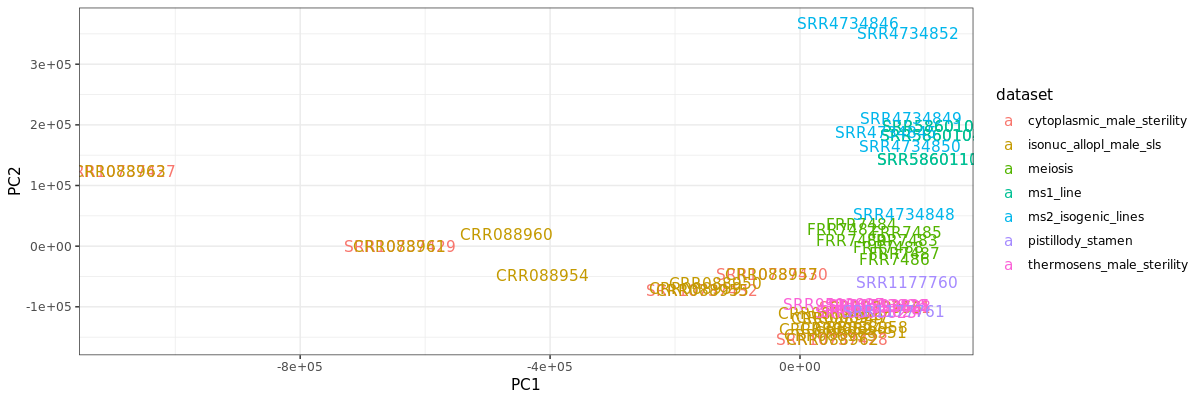

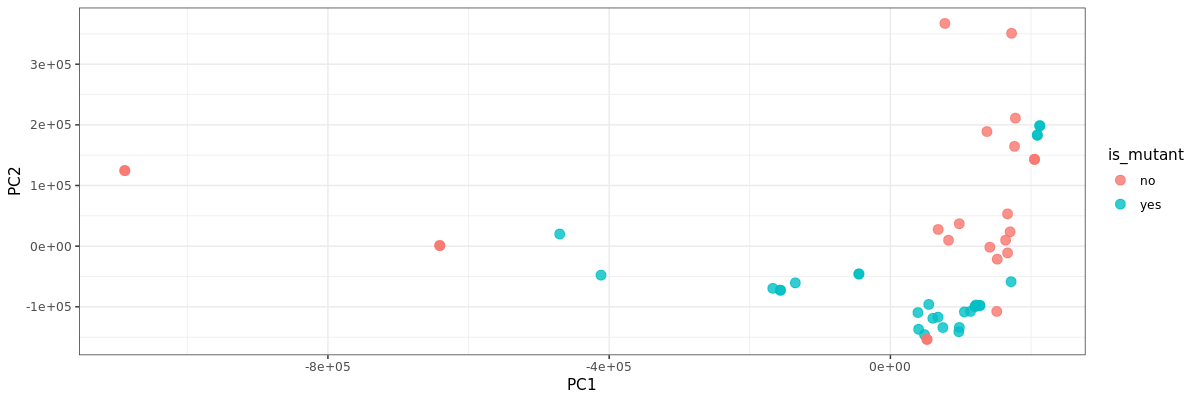

In [23]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_anther2, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_anther2, color_by = 'is_mutant',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

In [24]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
#plot_bootstrap(so_anther2, 'Horvu_MOREX_7H01G200700', color_by = 'is_mutant',units='scaled_reads_per_base')

In [25]:
# create models
so_anther2 <- sleuth_fit(so_anther2, ~dataset + is_mutant, 'full')
so_anther2 <- sleuth_fit(so_anther2, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
6 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI7B01G499500, TraesCHI1B01G357800, TraesCHI1D01G040900, TraesCHI5A01G280900, TraesCHI7A01G270800, TraesCHIUn01G298600
computing variance of betas
fitting measurement error models
shrinkage estimation
7 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: TraesCHI7B01G499500, TraesCHI1B01G357800, TraesCHI1D01G040900, TraesCHI5A01G280900, TraesCHI6B01G279000, TraesCHI7A01G270800, TraesCHIUn01G298600
computing varia

In [26]:
# perform DGE test
so_anther2 <- sleuth_lrt(so_anther2, 'reduced', 'full')

In [27]:
models(so_anther2)

[  full  ]
formula:  ~dataset + is_mutant 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetthermosens_male_sterility
 	is_mutantyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetisonuc_allopl_male_sls
 	datasetmeiosis
 	datasetms1_line
 	datasetms2_isogenic_lines
 	datasetpistillody_stamen
 	datasetthermosens_male_sterility


In [28]:
table_anther2 <- sleuth_results(so_anther2, 'reduced:full', 'lrt', show_all = FALSE)
sig_anther2_1 <- filter(table_anther2, qval <= 0.1)
glimpse(sig_anther2_1)
sig_anther2_05 <- filter(table_anther2, qval <= 0.05)
glimpse(sig_anther2_05)
sig_anther2_01 <- filter(table_anther2, qval <= 0.01)
glimpse(sig_anther2_01)
# look at table and few of 0.05
head(sig_anther2_05, 5)

Rows: 41,365
Columns: 12
$ target_id       <chr> "TraesCHI3B01G103200", "TraesCHI2A01G569200", "TraesC…
$ pval            <dbl> 8.694956e-13, 2.109600e-12, 2.994907e-12, 5.372352e-1…
$ qval            <dbl> 5.670068e-08, 6.510030e-08, 6.510030e-08, 8.758411e-0…
$ test_stat       <dbl> 51.11862, 49.37930, 48.69197, 47.54617, 45.95785, 44.…
$ rss             <dbl> 50.008601, 51.137559, 43.203887, 38.889562, 81.188588…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 3.312027, 3.388608, 2.555188, 2.246352, 1.837935, 5.6…
$ var_obs         <dbl> 3.9060146, 3.1371692, 2.1702088, 1.6311255, 1.9855253…
$ tech_var        <dbl> 0.106022373, 0.110858871, 0.124097607, 0.135133473, 0…
$ sigma_sq        <dbl> 1.0052799, 1.0255313, 0.8359888, 0.7290790, 1.6448801…
$ smooth_sigma_sq <dbl> 0.21957138, 0.20860209, 0.34225648, 0.40030801, 0.480…
$ final_sigma_sq  <dbl> 1.0052799, 1.0255313, 0.8359888, 0.7290790, 1.6448801…
Rows: 27,319
Columns: 12
$ 

,target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI3B01G103200,8.694956e-13,5.670068e-08,51.11862,50.00860,1,3.312027,3.906015,0.1060224,1.0052799,0.2195714,1.0052799
2,TraesCHI2A01G569200,2.109600e-12,6.510030e-08,49.37930,51.13756,1,3.388608,3.137169,0.1108589,1.0255313,0.2086021,1.0255313
3,TraesCHI3D01G395800,2.994907e-12,6.510030e-08,48.69197,43.20389,1,2.555188,2.170209,0.1240976,0.8359888,0.3422565,0.8359888
4,TraesCHI6A01G297500,5.372352e-12,8.758411e-08,47.54617,38.88956,1,2.246352,1.631125,0.1351335,0.7290790,0.4003080,0.7290790
5,TraesCHI7B01G127100,1.208251e-11,1.575825e-07,45.95785,81.18859,1,1.837935,1.985525,0.1593108,1.6448801,0.4801435,1.6448801


In [29]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
write.table(sig_anther2_1, file = "deg_wheat_anther2_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_anther2_05, file = "deg_wheat_anther2_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_anther2_01, file = "deg_wheat_anther2_signif0_01.csv", sep = ",", col.names = TRUE)

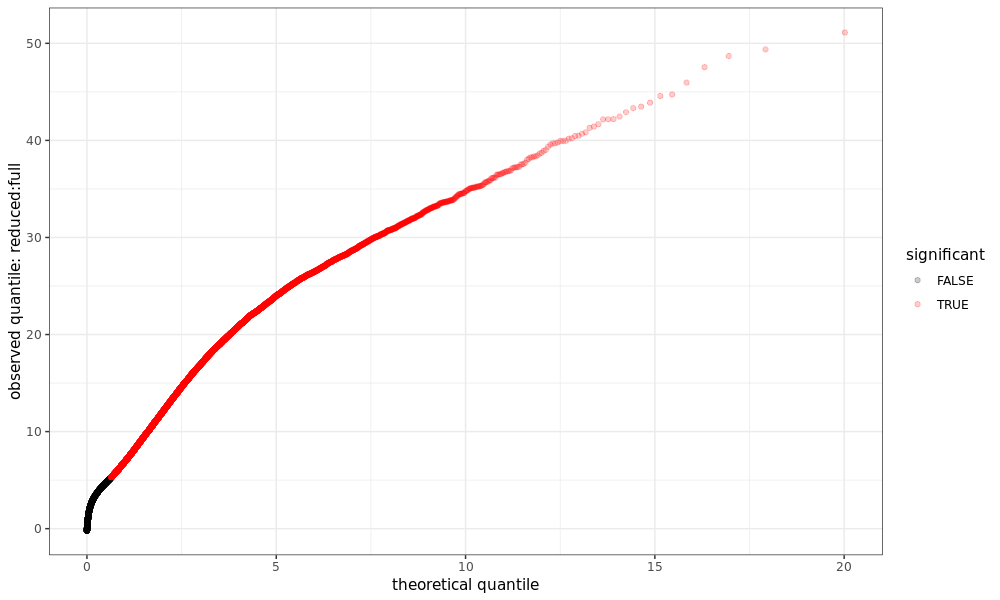

In [30]:
plot_qq(so_anther2, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

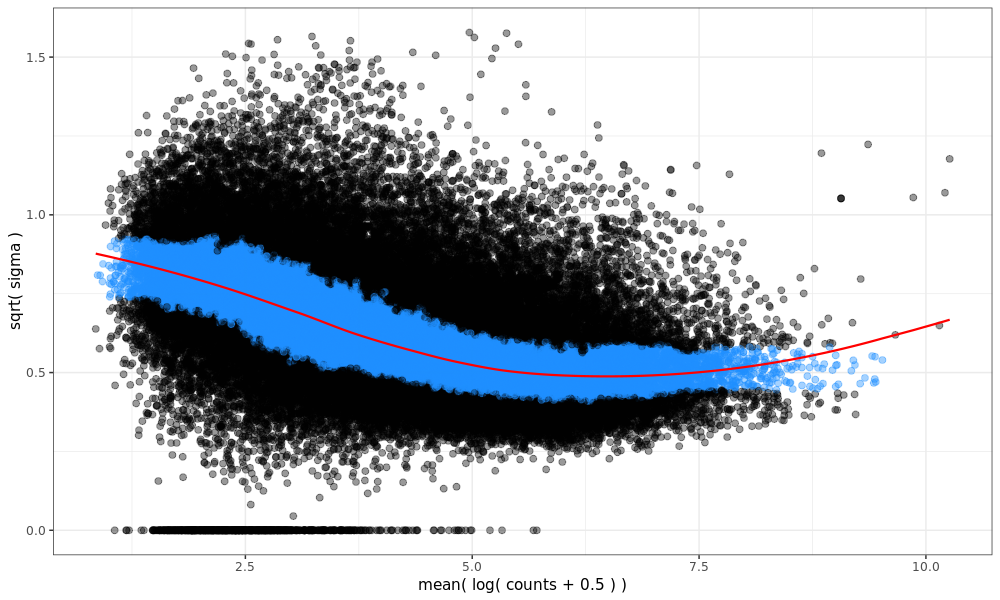

In [31]:
plot_mean_var(so_anther2,which_model="full")

In [33]:
sleuth_live_settings(test_type = "lrt")
sleuth_live(so_anther1, settings = sleuth_live_settings())
# in order to display: open new terminal tab and type: `ssh -L localhost:42427:localhost:42427 vanda.marosi@bee`
# number after localhost has to match the last number written in the output
# after this, copy and enter http site address 

$test_type
[1] "lrt"


Listening on http://127.0.0.1:42427


In [32]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] shiny_1.3.2         pheatmap_1.0.12     vsn_3.54.0         
 [4] Biobase_2.46.0      BiocGenerics_0.32.0 RColorBrewer_1.1-2 
 [7] cowplot_1.0.0       forcats_0.5.0       stringr_1.4.0      
[10] dplyr_0.8.5         purrr_0.3.4         readr_1.3.1        
[13] tidyr_1.0.2       